# Consideration on the Numerical Gradient Check

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple
)

In [2]:
import sys
import os 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import inspect
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
np.set_printoptions(threshold=sys.maxsize)

In [5]:
from common import (
    logistic_log_loss,
    logistic_log_loss_gradient,
    categorical_log_loss,
    cross_entropy_log_loss,
    sigmoid,
    sigmoid_gradient,
    numerical_jacobian,
    xavier,
    he,
    uniform
)

In [6]:
N = 500
left=-20
right=20

In [26]:
while not (p:= np.random.uniform(-1, 1)): pass
p

0.8132396575127392

---

# Saturation

When gradient get closer to 0, the gradient descent / back propagation will not progress further.

## Sigmoid 

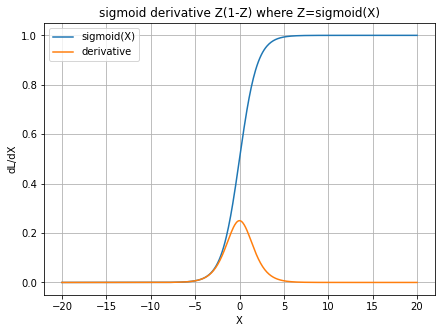

In [7]:
x = np.linspace(left,right,N)
z = sigmoid(x)
#plt.plot(x, z)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x, sigmoid(x), label="sigmoid(X)")
ax.plot(x, sigmoid_gradient(x), label="derivative")

ax.set_xlabel("X")
ax.set_ylabel("dL/dX")
ax.set_title("sigmoid derivative Z(1-Z) where Z=sigmoid(X)")
ax.legend()
ax.grid(True)
#plt.show()

In [8]:
def sigmoid_reverse(y):
    """
    Args:
        y: y=sigmoid(x)
    Returns:
        x: x that gives y=sigmoid(x)
    """
    return np.log(y/(1-y))

In [9]:
print(np.log(1e-15))
print(sigmoid(np.log(1e-15)))
print(sigmoid(-20.))

-34.538776394910684
9.999999899999984e-09
9.999999899999984e-09


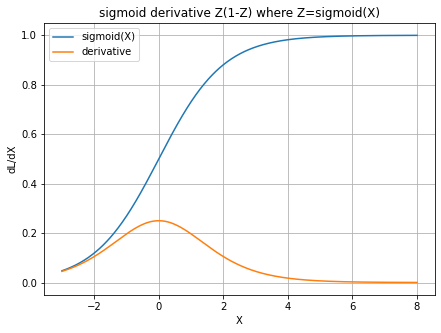

In [10]:
left = -3
right = 8
x = np.linspace(left,right,N)
z = sigmoid(x)
#plt.plot(x, z)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x, sigmoid(x), label="sigmoid(X)")
ax.plot(x, sigmoid_gradient(x), label="derivative")

ax.set_xlabel("X")
ax.set_ylabel("dL/dX")
ax.set_title("sigmoid derivative Z(1-Z) where Z=sigmoid(X)")
ax.legend()
ax.grid(True)
#plt.show()

In [11]:
k = 1e-5
print(sigmoid_reverse(k))
print(sigmoid_gradient(sigmoid_reverse(k)))

-11.512915464920228
9.9999e-06


In [12]:
x = 10.
print(sigmoid(x))
print(sigmoid_gradient(x))

0.9999546021312976
4.5395807735907655e-05


---

# Offsets to mitigate inf 

## log(x)

As ```x``` get closer to 0, the value $log(x) \rightarrow -inf$ and its gradient $\frac {\partial log(x)}{\partial x} \rightarrow inf$. The domain of ```x``` needs to be carefully considered to avoid ```inf```.

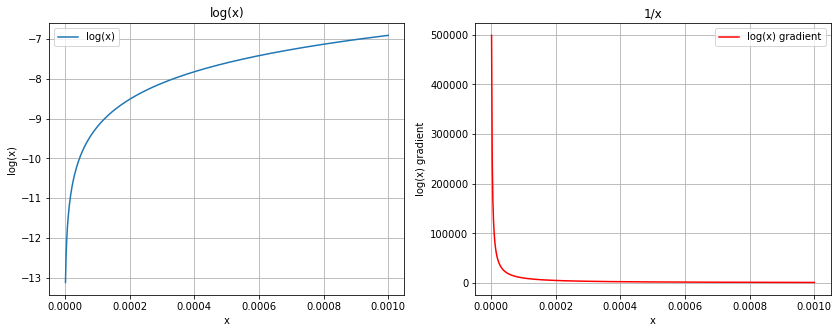

In [13]:
h = 1e-3
x = np.linspace(0,h,N)[1::]    # Excluding 0 to avoid log(0)
fig, ax = plt.subplots(1,2, figsize=(14,5)) 
ax[0].plot(x, np.log(x), label='log(x)')  
ax[0].set_xlabel('x')  # Add an x-label to the axes.
ax[0].set_ylabel('log(x)')  # Add a y-label to the axes.
ax[0].set_title("log(x)")  # Add a title to the axes.
ax[0].grid()
ax[0].legend()  # Add a legend.

ax[1].plot(x, 1/x, label='log(x) gradient', color='r')  
ax[1].set_xlabel('x')  # Add an x-label to the axes.
ax[1].set_ylabel('log(x) gradient')  # Add a y-label to the axes.
ax[1].set_title("1/x")  # Add a title to the axes.
ax[1].grid()
ax[1].legend()  # Add a legend.

## k for log(+k)

Adding a small value ```k``` log(x+k) to avoid log(0)->np.inf by log(0+k) causes clipping effect. For ```k=1e-6```, values of ```np.log(x+k)``` are clipped by ```np.log(k) = -13.815510557964274```. This effects on related functions using log.


In [14]:
print(np.log(1e-2))
print(sigmoid(np.log(1e-5)))

print(np.log(1e-6))
print(sigmoid(np.log(1e-6)))

print(np.log(1e-7))
print(np.log(1e-8))
print(np.log(1e-9))
print(np.log(1e-10))


-4.605170185988091
9.999900000999989e-06
-13.815510557964274
9.999990000010005e-07
-16.11809565095832
-18.420680743952367
-20.72326583694641
-23.025850929940457


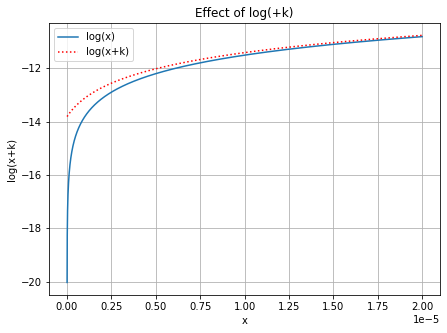

In [15]:
k = 1e-6
x = np.linspace(0,0.00002,10000)[1::]    # Excluding 0 to avoid log(0)
y = np.log(x+k)[1:-1:10]
fig, ax = plt.subplots(figsize=(7,5)) 
ax.plot(x, np.log(x), label='log(x)')  
ax.plot(
    x[0:-1:5], np.log(x+k)[0:-1:5], label='log(x+k)', 
    color='red', linestyle='dotted'
)
ax.set_xlabel('x')  # Add an x-label to the axes.
ax.set_ylabel('log(x+k)')  # Add a y-label to the axes.
ax.set_title("Effect of log(+k)")  # Add a title to the axes.
ax.grid()
ax.legend()  # Add a legend.

When ```x``` gets closer to 0, the effect of ```log(+k)``` cannot be negligible because $\frac {\partial log(x+k-h)}{\partial h} >> \frac {\partial log(x-h)}{\partial h}$. Hence need to be careful with the range of ```x``` in relation to ```k``` for the numerical gradient ```gn``` to be relatively close to the analytical gradient ```g``` with the delta ```h``` in the calculation $\frac {f(x+h) - f(x-h)}{2h}$.

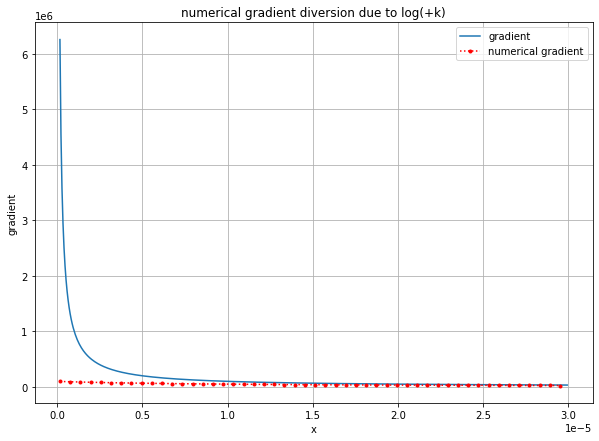

In [16]:
h = 1e-7
k = 1e-05
assert h < k
x = np.linspace(h,3e-05,500)[1:-1]

def log_gn(X, k, h):
    """Numerical gradient for logistic log loss"""
    return [
        numerical_jacobian(lambda x: np.log(x+k), x, delta=h)
        for x in X 
    ]


fig, ax = plt.subplots(figsize=(10,7)) 
ax.plot(x, 1/x, label='gradient')  
ax.plot(
    x[0:-1:10], 
    log_gn(x, k, h)[0:-1:10], 
    color="red", linestyle='dotted', marker='o', markersize=3,
    label='numerical gradient'
)
ax.set_xlabel('x')  # Add an x-label to the axes.
ax.set_ylabel('gradient')  # Add a y-label to the axes.
ax.set_title("numerical gradient diversion due to log(+k)")
ax.grid()
ax.legend()  # Add a legend.

---

# Impact analyses


## Logistic log loss

For ```T == 1```, the logistic log loss is clipped by ```-np.log(k) = 13.815510557964274``` as its max value, because it is defined ```logistic_log_loss(x) = -np.log(x+k)```.

### Numeric gradient of Logistic log loss

Because the value is clipped, the derivative satulates and starts diverging from the analytical gradient when the X value gets closer to ```abs(X) = 13.815510557964274``` and becomes ```0```. However, the true gradient is ```1``` as $\frac {\partial log(z)}{\partial x} = (Z-T) = 1$ where $T = 1 \; Z = sigmoid(x))$

In [17]:
def gn(X, t, k):
    """Numerical gradient for logistic log loss"""
    return [
        numerical_jacobian(lambda x: logistic_log_loss(P=sigmoid(x), T=t, offset=k), x) 
        for x in X 
    ]

<Figure size 1440x1080 with 0 Axes>

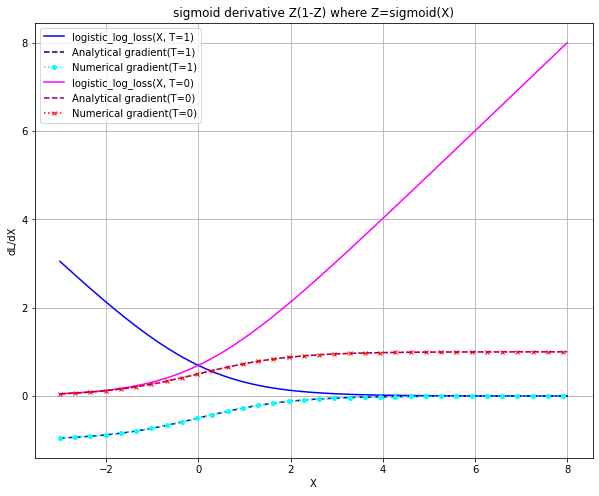

In [18]:
X = np.linspace(left,right,N)
T0 = np.zeros(N)
L0 = lambda x: logistic_log_loss(P=sigmoid(x), T=0)
GN0 = [numerical_jacobian(L0, x) for x in X ]
T1 = np.ones(N)
L1 = lambda x: logistic_log_loss(P=sigmoid(x), T=1)
GN1 = [numerical_jacobian(L1, x) for x in X ]

plt.figure(figsize=(20,15))
# --------------------------------------------------------------------------------
# T = 1
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(
    X,
    logistic_log_loss(sigmoid(X), T1, offset=k),
    color='blue', linestyle='solid',
    label="logistic_log_loss(X, T=1)"
)
ax.plot(
    X, 
    logistic_log_loss_gradient(X, T1),
    color='navy', linestyle='dashed',
    label="Analytical gradient(T=1)"
)

ax.plot(
    X[0:-1:15], 
    gn(X, 1, 1e-6)[0:-1:15],
    color='cyan', linestyle='dotted', marker='o', markersize=4,
    label="Numerical gradient(T=1)"
)
# --------------------------------------------------------------------------------
# T = 0
# --------------------------------------------------------------------------------
ax.plot(
    X, 
    logistic_log_loss(sigmoid(X), T0, offset=k), 
    color='magenta', linestyle='solid',
    label="logistic_log_loss(X, T=0)"
)
ax.plot(
    X, 
    logistic_log_loss_gradient(X, T0),
    color='purple', linestyle='dashed', 
    label="Analytical gradient(T=0)"
)
ax.plot(
    X[0:-1:15],
    gn(X, 0, 1e-6)[0:-1:15],
    color='red', linestyle='dotted', marker='x', markersize=4,
    label="Numerical gradient(T=0)"
)

ax.set_xlabel("X")
ax.set_ylabel("dL/dX")
ax.set_title("sigmoid derivative Z(1-Z) where Z=sigmoid(X)")
ax.legend()
ax.grid(True)
#plt.show()

# k decides the boundary
The usable X area 

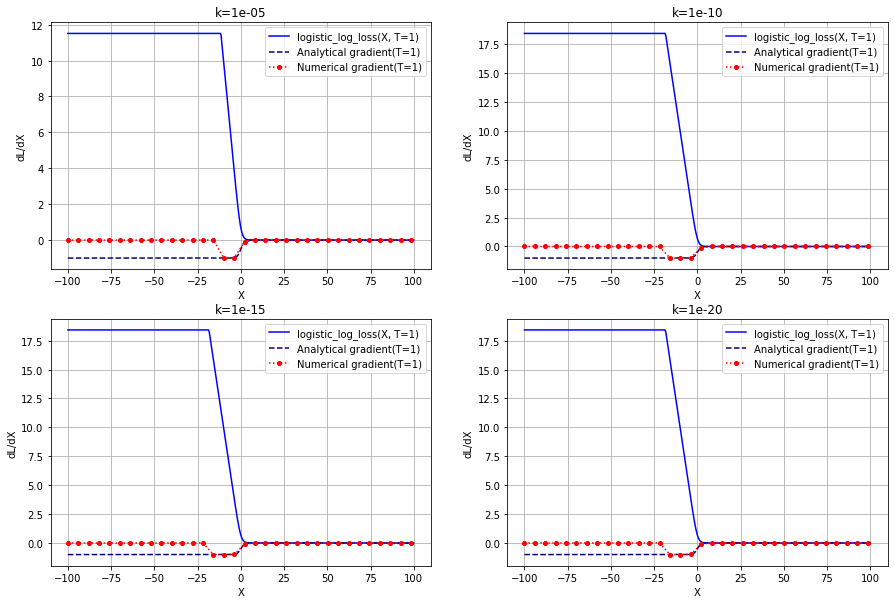

In [19]:
left=-100
right=100
K = [[1e-5, 1e-10],[1e-15, 1e-20]]
X = np.linspace(left,right,N)
T1 = np.ones(N)

fig, ax = plt.subplots(2,2, figsize=(15,10))
for r,c in product([0,1], repeat=2):
    L1 = lambda x: logistic_log_loss(P=sigmoid(x), T=1, offset=K[r][c])
    GN1 = [numerical_jacobian(L1, x) for x in X ]


    # --------------------------------------------------------------------------------
    # T = 1
    # --------------------------------------------------------------------------------

    ax[r][c].plot(
        X,
        logistic_log_loss(sigmoid(X), T1, offset=K[r][c]),
        color='blue', linestyle='solid',
        label="logistic_log_loss(X, T=1)"
    )
    ax[r][c].plot(
        X, 
        logistic_log_loss_gradient(X, T1),
        color='navy', linestyle='dashed',
        label="Analytical gradient(T=1)"
    )
    ax[r][c].plot(
        X[0:-1:15], 
        gn(X, 1, K[r][c])[0:-1:15],
        color='red', linestyle='dotted', marker='o', markersize=4,
        label="Numerical gradient(T=1)"
    )

    ax[r][c].set_xlabel("X")
    ax[r][c].set_ylabel("dL/dX")
    ax[r][c].legend()
    ax[r][c].grid(True)
    ax[r][c].set_title(f"k={K[r][c]}")
#plt.show()